In [1]:
import os

os.chdir("../../")

import statsmodels.tsa.api as smt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=1.15, style="whitegrid")

In [5]:
ts_data = ingestion.read_combined()

d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


### Train and test set

In [7]:
ts_data = ts_data.dropna(subset=["temperature_capped", "consumption"])
X = ts_data[["temperature_capped", "weekend"]]
y = ts_data["consumption"]

X_train = X[:"2020"]
X_test = X["2021":]
y_train = y[:"2020"]
y_test = y["2021":]

# AutoReg with lag 1 and external regressors
model = smt.AutoReg(y_train, lags=[1, 45], exog=X_train)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                             
===============================================================================
Dep. Variable:             consumption   No. Observations:                 1553
Model:             Restr. AutoReg-X(7)   Log Likelihood              -20462.464
Method:                Conditional MLE   S.D. of innovations         135510.985
Date:                 Sat, 15 Apr 2023   AIC                          40936.928
Time:                         15:01:40   BIC                          40968.989
Sample:                     10-08-2016   HQIC                         40948.854
                          - 12-31-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                2.02e+06   4.06e+04     49.790      0.000    1.94e+06     2.1e+06
consumption.L1         0.5193      0.011     48.676      0.000       0.498       0.540
consumption.L7         0.0285      0.007      4.252      0.000       0.015       0.042
temperature_capped -7.632e+04   1569.842    -48.615      0.000   -7.94e+04   -7.32e+04
weekend            -2.404e+05   7861.542    -30.581      0.000   -2.56e+05   -2.25e+05
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3862           -0.0000j            1.3862           -0.0000
AR.2            1.1422           -1.0904j            1.5791           -0.1213
AR.3            1.1422           +1.0904j            1.5791            0.1213
AR.4           -0.2222           -1.7363j            1.7504           -0.2703
AR.5           -0.2222           +1.7363j            1.7504            0.2703
AR.6           -1.6131           -0.8444j            1.8207           -0.4232
AR.7           -1.6131           +0.8444j            1.8207            0.4232
-----------------------------------------------------------------------------
"""

In [9]:
predictions = results.get_prediction(start=0, end="2022-11-28", exog=X_train, exog_oos=X_test)
predictions_cofindence_intervals = predictions.conf_int()

modelled_consumption = predictions.predicted_mean

(0.0, 7000000.0)

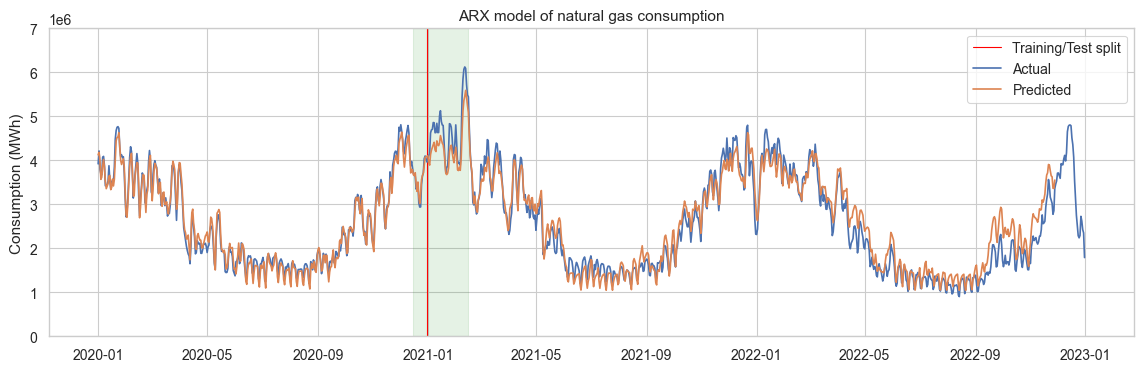

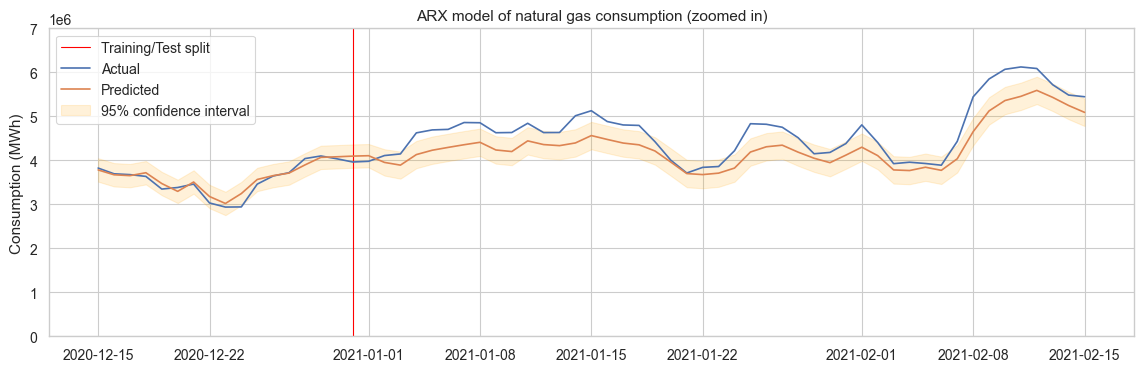

In [10]:
# Plot 1 - multiple years
fig, ax = plt.subplots(figsize=(14, 4))

ax.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax.axvspan(
    pd.Timestamp("2020-12-15"), pd.Timestamp("2021-02-15"), color="green", alpha=0.1
)
ax.plot(y["2020":], label="Actual")
ax.plot(modelled_consumption["2020":], label="Predicted")
ax.set_ylabel("Consumption (MWh)")
ax.legend()
ax.set_title("ARX model of natural gas consumption")
ax.set_ylim(0, 7 * 10**6)

# Plot 2 - zoomed in
fig, ax2 = plt.subplots(figsize=(14, 4))

ax2.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax2.plot(y["2020-12-15":"2021-02-15"], label="Actual")
ax2.plot(modelled_consumption["2020-12-15":"2021-02-15"], label="Predicted")
ax2.fill_between(
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0].index,
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 0],
    predictions_cofindence_intervals.loc["2020-12-15":"2021-02-15"].iloc[:, 1],
    color="orange",
    alpha=0.15,
    label="95% confidence interval",
)
ax2.set_ylabel("Consumption (MWh)")
ax2.legend()
ax2.set_title("ARX model of natural gas consumption (zoomed in)")
ax2.set_ylim(0, 7 * 10**6)

In [11]:
# Mean Absolute Percentage Error (MAPE) for 60days after training data cutoff
mape_14d = (
    abs(y["2021-01-01":"2021-01-14"] - modelled_consumption["2021-01-01":"2021-01-14"])
    / y["2021-01-01":"2021-01-14"]
).mean() * 100

mape_60d = (
    abs(y["2021-01-01":"2021-02-28"] - modelled_consumption["2021-01-01":"2021-02-28"])
    / y["2021-01-01":"2021-02-28"]
).mean() * 100

mape_365d = (
    abs(y["2021-01-01":"2022-01-01"] - modelled_consumption["2021-01-01":"2022-01-01"])
    / y["2021-01-01":"2022-01-01"]
).mean() * 100


print(f"MAPE : {mape_14d:.2f}% for 14 days")
print(f"MAPE : {mape_60d:.2f}% for 60 days")
print(f"MAPE : {mape_365d:.2f}% for 365 days")

MAPE : 8.04% for 14 days
MAPE : 6.30% for 60 days
MAPE : 7.96% for 365 days
